In [185]:
# function for simulating weiner/brownian process 
def Brownian(N,days):
    """
    N is the number of time steps in a day
    days is the total # of days
    """
    b = np.random.normal(0.,1.,days*N)*np.sqrt(1/N)
    # brownian increments , variance is considered to be 1/N CHECK? 
    W = np.cumsum(b)
    W=np.insert(W,0,0.)
    # brownian path
    return W, b

 # geometric brownian motion function 
def GBM(So, mu, sigma, W, N,days):
    """
    So :is the start price
    mu :is mean of price
    sigma: is the volatility
    N :is the number of time steps in a day days: is the total # of days
    """
    S = []
    S.append(So)
    t= np.linspace(0.,1.,N+1)
    for i in range(1,int(days*N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        #CHECK if the formula of the process is correct 
        diffusion = sigma * np.sqrt(t[i])*np.random.normal(0,1)
        S_temp = So*np.exp(drift + diffusion) 
        S.append(S_temp)
    return S

def generate_gbm_prices(start_price,instance,N,days,mu,sigma):
    """
    start_price: is the initial price same as So as above instance: are number of simulations you want increments: are increments in a day, same as N above days: # of total no of trading days
    """
    ins=instance
    prices=pd.DataFrame()
    for i in range(1,ins+1):
        W=Brownian(N,days)[0] #here what to put BM or increments 
        So=start_price
        temp=GBM(So,mu,sigma,W,N,days) 
        prices=pd.concat([prices,pd.Series(temp)],axis=1)
    prices.columns=np.arange(1,ins+1,1) 
    return prices 

 #the below function labels the data properly 
def give_labels(N,days,data):
    obs_nu = np.arange(0,N+1) 
    final_prices=pd.DataFrame() 
    for i in range(1,days+1):
        temp_ = data.loc[N*(i-1):N*i] 
        day_label=[]
        for j in range(N+1):
            day_label.append('day'+str(i))
        tuples=list(zip(day_label,obs_nu))
        index=pd.MultiIndex.from_tuples(tuples,names=['DAY','#INCREMENT'])
        temp_1=pd.DataFrame(temp_.values,index=index)
        final_prices=pd.concat([final_prices,temp_1])
    return final_prices

def ochl_data(instances,N,days,data): 
    data_fin=pd.DataFrame()
    zz=data
    for i in range(instances):
        for j in range(1,days+1): 
            temp=pd.DataFrame({'OPEN':zz.loc['day'+str(j)][i][0],
                                            "CLOSE":zz.loc['day'+str(j)][i][N],
                                         'HIGH':max(zz.loc['day'+str(j)][i]),
                                        'LOW': min(zz.loc['day'+str(j)][i])},
                                 index=pd.MultiIndex.from_tuples([('Simulation'+str(i+1),
                                     'day'+str(j))],names=['Simulation#','DAY']))
            data_fin=pd.concat([data_fin,temp]) 
    return data_fin

In [186]:
import cvxopt
from cvxopt import solvers
from cvxopt import matrix
import numpy as np
from scipy.linalg import null_space
import math
from sympy import Matrix
import sympy
import pandas as pd
import matplotlib.pyplot as plt

In [189]:
start_price=50
ins=400
N=20
days=1
mu=0
sigma=0.2
soln=generate_gbm_prices(start_price=start_price,instance=ins,N=N,days=days,mu=mu,sigma=sigma)#sample size is taken to be small #for illustration

In [190]:
soln

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
1,51.357734,51.439182,48.127822,53.233912,47.448775,46.901545,49.473598,50.219633,49.062463,51.321177,...,51.107626,47.307253,53.876968,47.949991,48.296347,49.987600,50.677399,50.299503,48.439822,50.774899
2,53.985155,49.249837,51.418733,50.142212,48.845206,47.810339,50.985040,47.936744,46.201683,52.012272,...,55.528187,53.529052,49.888062,48.524605,50.422420,47.886882,51.892166,52.595417,47.990133,45.853458
3,52.626858,46.921066,43.162488,54.630558,50.456881,48.467877,52.749682,48.430683,52.182087,59.091850,...,48.425901,48.283938,44.643540,53.258114,50.353821,47.856501,47.674784,45.570962,54.942980,45.346054
4,51.664863,49.938320,53.601138,53.898451,51.191742,44.865701,49.679958,45.063496,54.443012,47.919590,...,46.805286,46.190196,58.322985,47.195071,46.647878,45.289080,48.903302,52.132323,51.370561,51.058348
5,52.159623,45.279339,50.994028,53.388997,59.233771,51.803617,48.675494,43.669104,48.593649,48.392855,...,51.489771,48.931094,45.449593,55.473833,58.963645,49.096095,46.902190,39.610277,43.345305,59.763860
6,54.847277,60.240957,52.308494,42.452421,47.997441,44.440436,46.545344,60.253808,49.750399,45.403038,...,54.820923,48.084547,45.072602,54.839511,43.328319,44.976350,40.777750,56.724424,45.654693,53.333677
7,47.161659,45.519072,41.038927,39.101058,48.716405,54.141829,47.806248,48.181231,47.193532,41.468028,...,57.346245,47.456015,49.177080,57.389434,48.218499,56.994357,55.855296,45.284427,46.835428,46.865216
8,52.459340,49.996455,58.128104,55.593821,45.993205,45.622219,43.081318,43.603616,50.252014,55.557135,...,51.165849,51.215564,47.232136,58.530248,56.500970,52.986683,40.589385,42.493398,57.424405,46.429000
9,47.405275,45.012347,47.793457,44.000657,54.438452,47.000476,55.760116,55.841992,48.687857,67.108322,...,42.355712,45.105590,40.750423,53.902996,58.845792,43.461080,43.028339,54.300718,80.410832,45.128409


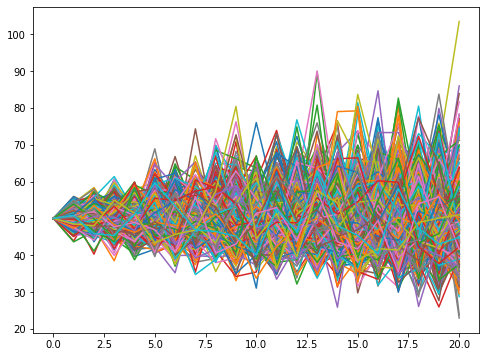

In [191]:
plt.figure(figsize=(8,6))
plt.plot(soln)
plt.show()

In [192]:
ac_w_lab= give_labels(N,days,soln)
ac_w_lab

0          1          2          3          4    \
DAY  #INCREMENT                                                          
day1 0           50.000000  50.000000  50.000000  50.000000  50.000000   
     1           51.357734  51.439182  48.127822  53.233912  47.448775   
     2           53.985155  49.249837  51.418733  50.142212  48.845206   
     3           52.626858  46.921066  43.162488  54.630558  50.456881   
     4           51.664863  49.938320  53.601138  53.898451  51.191742   
     5           52.159623  45.279339  50.994028  53.388997  59.233771   
     6           54.847277  60.240957  52.308494  42.452421  47.997441   
     7           47.161659  45.519072  41.038927  39.101058  48.716405   
     8           52.459340  49.996455  58.128104  55.593821  45.993205   
     9           47.405275  45.012347  47.793457  44.000657  54.438452   
     10          64.341734  46.944089  48.360635  52.834256  35.834907   
     11          48.112359  36.436167  50.081897  57.344413  53.678763   
     12          45.479561  60.260202  32.166186  60.028232  47.481628   
     13          69.728520  59.278314  44.997131  49.709197  60.610230   
     14          47.492435  47.447502  46.112670  50.845613  49.113176   
     15          52.663373  62.870105  40.609886  60.615460  49.962153   
     16          63.976985  37.522745  53.720585  60.306258  56.265219   
     17          51.296013  51.553702  37.643971  63.903917  68.359855   
     18          46.933514  56.898924  49.754760  43.733003  68.209411   
     19          51.378403  41.983281  57.918607  75.579394  52.424005   
     20          40.400439  50.137605  66.090463  31.930061  48.437852   

                       5          6          7          8          9    ...  \
DAY  #INCREMENT                                                         ...   
day1 0           50.000000  50.000000  50.000000  50.000000  50.000000  ...   
     1           46.901545  49.473598  50.219633  49.062463  51.321177  ...   
     2           47.810339  50.985040  47.936744  46.201683  52.012272  ...   
     3           48.467877  52.749682  48.430683  52.182087  59.091850  ...   
     4           44.865701  49.679958  45.063496  54.443012  47.919590  ...   
     5           51.803617  48.675494  43.669104  48.593649  48.392855  ...   
     6           44.440436  46.545344  60.253808  49.750399  45.403038  ...   
     7           54.141829  47.806248  48.181231  47.193532  41.468028  ...   
     8           45.622219  43.081318  43.603616  50.252014  55.557135  ...   
     9           47.000476  55.760116  55.841992  48.687857  67.108322  ...   
     10          41.988693  55.113412  55.036821  49.201318  57.897562  ...   
     11          34.678260  40.795635  49.647550  38.881520  52.700715  ...   
     12          47.166963  55.437976  53.962302  44.249208  45.992977  ...   
     13          53.647075  49.298523  38.984562  43.913636  55.101071  ...   
     14          70.194465  44.265617  54.019463  53.713601  36.420695  ...   
     15          29.752227  32.945304  42.625979  46.781045  38.339369  ...   
     16          48.215491  47.313258  45.554283  50.252351  47.533777  ...   
     17          62.231637  51.071365  43.105082  39.067884  43.566948  ...   
     18          59.214272  45.179926  49.240182  55.459435  37.470337  ...   
     19          29.381762  38.960442  33.050851  75.853128  71.439219  ...   
     20          44.096641  40.467249  43.982298  49.713551  41.277148  ...   

                       390        391        392        393        394  \
DAY  #INCREMENT                                                          
day1 0           50.000000  50.000000  50.000000  50.000000  50.000000   
     1           51.107626  47.307253  53.876968  47.949991  48.296347   
     2           55.528187  53.529052  49.888062  48.524605  50.422420   
     3           48.425901  48.283938  44.643540  53.258114  50.353821   
     4           46.805286  46.190196  58.322985  47.19507

In [193]:
final=ochl_data(ins,N,days,ac_w_lab)

In [194]:
final

,,OPEN,CLOSE,HIGH,LOW
Simulation#,DAY,,,,
Simulation1,day1,50.0,40.400439,69.728520,40.400439
Simulation2,day1,50.0,50.137605,62.870105,36.436167
Simulation3,day1,50.0,66.090463,66.090463,32.166186
Simulation4,day1,50.0,31.930061,75.579394,31.930061
Simulation5,day1,50.0,48.437852,68.359855,35.834907
Simulation6,day1,50.0,44.096641,70.194465,29.381762
Simulation7,day1,50.0,40.467249,55.760116,32.945304
Simulation8,day1,50.0,43.982298,60.253808,33.050851
Simulation9,day1,50.0,49.713551,75.853128,38.881520


In [195]:
final['ln O']= np.log(final["OPEN"])
final['ln C']= np.log(final["CLOSE"])
final['ln H']= np.log(final["HIGH"])
final['ln L']= np.log(final["LOW"])
final['u^2']=(np.log(final["HIGH"])-np.log(final["OPEN"]))**2
final['d^2']=(np.log(final["LOW"])-np.log(final["OPEN"]))**2
final['c^2']=(np.log(final["CLOSE"])-np.log(final["OPEN"]))**2
final['ud']= np.sqrt(final['u^2'])*np.sqrt(final['d^2'])
final['uc']= np.sqrt(final['u^2'])*np.sqrt(final['c^2'])
final['dc']= np.sqrt(final['d^2'])*np.sqrt(final['c^2'])


In [196]:
final

,,OPEN,CLOSE,HIGH,LOW,ln O,ln C,ln H,ln L,u^2,d^2,c^2,ud,uc,dc
Simulation#,DAY,,,,,,,,,,,,,,
Simulation1,day1,50.0,40.400439,69.728520,40.400439,3.912023,3.698841,4.244609,3.698841,0.110614,0.045447,4.544672e-02,0.070902,0.070902,0.045447
Simulation2,day1,50.0,50.137605,62.870105,36.436167,3.912023,3.914771,4.141071,3.595562,0.052463,0.100148,7.553301e-06,0.072485,0.000629,0.000870
Simulation3,day1,50.0,66.090463,66.090463,32.166186,3.912023,4.191024,4.191024,3.470916,0.077842,0.194576,7.784181e-02,0.123070,0.077842,0.123070
Simulation4,day1,50.0,31.930061,75.579394,31.930061,3.912023,3.463548,4.325184,3.463548,0.170702,0.201130,2.011299e-01,0.185292,0.185292,0.201130
Simulation5,day1,50.0,48.437852,68.359855,35.834907,3.912023,3.880282,4.224786,3.578922,0.097821,0.110956,1.007519e-03,0.104181,0.009928,0.010573
Simulation6,day1,50.0,44.096641,70.194465,29.381762,3.912023,3.786384,4.251269,3.380374,0.115088,0.282651,1.578526e-02,0.180360,0.042623,0.066796
Simulation7,day1,50.0,40.467249,55.760116,32.945304,3.912023,3.700493,4.021059,3.494849,0.011889,0.174034,4.474495e-02,0.045487,0.023064,0.088245
Simulation8,day1,50.0,43.982298,60.253808,33.050851,3.912023,3.783787,4.098566,3.498047,0.034798,0.171376,1.644441e-02,0.077224,0.023921,0.053086
Simulation9,day1,50.0,49.713551,75.853128,38.881520,3.912023,3.906278,4.328799,3.660519,0.173702,0.063254,3.301022e-05,0.104821,0.002395,0.001445


In [197]:
final.to_excel("400_20_0_0.2_sim_new.xlsx")